This notebook is an extension of [Waste Sorter by Collindching](https://github.com/collindching/waste-sorter/blob/master/Waste%20sorter.ipynb) and parts of code snippets and code cells have been heavily referred with some tweaks from the above mentioned link.

Primary focus of this notebook to extend the Model's performance by improving the accuracy and reducing the misclassified error which was noticed earlier.

This notebook is built on fast.ai v2 library. More information can be found here https://course.fast.ai/. Current version of Collindching's notebook supported fast ai v1 version. So, some tweaks have been done to support that.



## Why waste sorting?

Recycling contamination occurs when waste is incorrectly disposed of - like recycling a pizza box with oil on it (compost). Or when waste is correctly disposed of but incorrectly prepared - like recycling unrinsed jam jars.

Contamination is a [huge problem](http://mediaroom.wm.com/the-battle-against-recycling-contamination-is-everyones-battle/) in the recycling industry that can be mitigated with automated waste sorting. Just for kicks, I thought I'd try my hand at prototyping an image classifier to classify trash and recyclables - this classifier could have applications in an optical sorting system.

## Waste Classifier Model Pipeline

In this project, I'll try to reduce the misclassification error which was noticed earlier (link mentioned above)

We will follow the same prior steps

1. Extract data
2. Investigate on why more misclassification happened in the first place.
3. Model Data
4. Predictions on New Images
5. Comparing our Results to previous version of Notebook 
6. Further enhancements and Research

The below code cell is simply a upgrade step of fastai library, this is done to ensure we have latest fixes in one place. I noticed while plotting top losses of images that there were few empty plots, and this was the quick fix I could find. So, to be on safer side this additional step is performed.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install --upgrade git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-s_v1f852
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-s_v1f852


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [ ]:
# Alternatively using the code to work it through, by mounting the google drive..
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Copying and extracting the dataset fetched from the site..
!cp -r gdrive/MyDrive/dataset-resized.zip .
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [ ]:
# A basic sanity check to ensure the waste categories (images) are in place or not.
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastic', 'trash', 'cardboard', 'metal', 'glass', 'paper', '.DS_Store']

## 2. Organize images into different folders

Now that we've extracted the data, I'm going to split images up into train, validation, and test image folders with a 50-25-25 split. First, I'll define some functions that will help me quickly build it. If you're not interested in building the data set, you can just run this ignore it.

In [ ]:
?random

In [ ]:
f = os.path.join('dataset-resized', 'plastic')
n = len(os.listdir(f))
k = random.sample(list(range(1,n+1)),int(.5*n))
print(k)

[254, 390, 231, 242, 334, 195, 404, 108, 49, 250, 15, 458, 428, 200, 222, 312, 391, 393, 2, 357, 229, 137, 370, 411, 118, 303, 53, 163, 16, 12, 14, 333, 278, 5, 196, 352, 111, 217, 372, 472, 271, 114, 392, 225, 482, 284, 120, 177, 119, 347, 113, 481, 236, 149, 453, 214, 285, 329, 52, 96, 323, 371, 152, 62, 381, 171, 460, 365, 257, 445, 260, 344, 98, 156, 146, 301, 256, 259, 202, 302, 18, 246, 125, 418, 207, 213, 341, 89, 188, 281, 360, 346, 378, 192, 45, 439, 340, 261, 56, 84, 267, 476, 190, 251, 376, 454, 241, 23, 158, 361, 315, 304, 297, 399, 332, 88, 87, 258, 117, 7, 103, 277, 465, 434, 208, 264, 435, 296, 181, 430, 138, 338, 440, 467, 3, 197, 263, 67, 266, 288, 106, 219, 29, 247, 187, 292, 437, 362, 405, 212, 249, 183, 397, 178, 1, 276, 373, 320, 314, 170, 235, 308, 443, 471, 91, 282, 300, 93, 47, 283, 131, 17, 37, 43, 9, 232, 8, 144, 128, 447, 57, 95, 356, 429, 36, 86, 82, 349, 442, 366, 140, 151, 233, 165, 255, 243, 59, 13, 160, 198, 176, 216, 97, 133, 384, 130, 262, 475, 468, 11

In [ ]:
# Cite - https://github.com/collindching/waste-sorter/blob/master/Waste%20sorter.ipynb
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    print("Folder path:{}".format(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    print("List of indices\n {}.\n.{}\n.{}".format(train, valid, test))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, We will follow the same convention as Imagenet architecture

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

In [ ]:
# Removing the folder if existed before..
path = Path(os.getcwd()+"/data")
subset = ['train', 'valid', 'test']
[shutil.rmtree(os.path.join(path, sub_folder)) for sub_folder in subset if os.path.exists(os.path.join(path, sub_folder))]

[None, None, None]

In [ ]:
#Cite - https://github.com/collindching/waste-sorter/blob/master/Waste%20sorter.ipynb
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

def verify_source_file(waste_type, dataset_ind):
  dataset_names = get_names(waste_type, dataset_ind)
  source_files = []
  for name in dataset_names:
    path = os.path.join(source_folder,name)
    if not os.path.exists(path):
      continue
    source_files.append(path)

  return source_files


## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    train_source_files = verify_source_file(waste_type, train_ind)
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_source_files = verify_source_file(waste_type, valid_ind)
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_source_files = verify_source_file(waste_type, test_ind)
    move_files(test_source_files,"data/test")

Folder path:dataset-resized/cardboard
List of indices
 [69, 292, 392, 33, 131, 61, 254, 390, 231, 242, 334, 195, 108, 49, 250, 15, 200, 222, 312, 2, 357, 229, 137, 370, 118, 303, 53, 163, 16, 12, 14, 333, 278, 5, 196, 352, 111, 217, 388, 271, 114, 225, 397, 284, 120, 177, 119, 347, 113, 236, 149, 374, 214, 285, 329, 52, 96, 323, 152, 62, 171, 257, 366, 260, 98, 156, 146, 301, 256, 259, 202, 302, 18, 246, 125, 207, 213, 89, 188, 281, 192, 45, 362, 261, 56, 84, 267, 372, 190, 251, 375, 241, 23, 158, 304, 297, 316, 88, 87, 258, 117, 7, 103, 277, 324, 383, 208, 264, 358, 181, 354, 138, 299, 3, 197, 263, 67, 266, 106, 219, 29, 247, 187, 336, 393, 212, 249, 183, 327, 178, 1, 170, 235, 365, 379, 91, 93, 47, 399, 17, 37, 43, 9, 232, 8, 144, 128, 402, 283, 205, 160, 48, 326, 75, 331, 262, 41, 66, 136, 244, 44, 169, 70, 166, 276, 76, 378, 180, 83, 342, 122, 30, 332, 80, 99, 306, 391, 204, 396, 287, 28, 65, 291, 265, 54, 338, 367, 210, 6, 58, 380, 102, 38, 10, 185, 42, 115, 294, 130, 174, 110].
.

I set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

Important things before we go any further, fast.ai uses Path extensively for handling image path which makes more convenient to not worry about the directory where the images have to be loaded from. 

In short, path is just the working directory where temporary files/models will be saved.

Path is used extensively in fastai reference.

In [ ]:
## Get the images from particular path...
path = Path(os.getcwd())/"data"
path

Path('/content/data')

In [ ]:
# Checking the counts of plastic, glass in train and validation set..
print("Plastic {}".format(len(os.listdir(str(path)+'/train/plastic'))))
print("Plastic {}".format(len(os.listdir(str(path)+'/valid/plastic'))))

print("Glass tr {}".format(len(os.listdir(str(path)+'/train/glass'))))
print("Glass Vl {}".format(len(os.listdir(str(path)+'/valid/glass'))))

Plastic 241
Plastic 120
Glass tr 242
Glass Vl 124


It seems like we are getting a normal split between train and valid set for glass images. Will look further to improve classification problem by augmentation and so on..


In [ ]:
#hide
tr_plastic_imgs = os.listdir(str(path)+'/train/plastic')

In [ ]:
os.listdir(str(path) + '/train/glass')

['glass151.jpg',
 'glass49.jpg',
 'glass106.jpg',
 'glass246.jpg',
 'glass446.jpg',
 'glass359.jpg',
 'glass163.jpg',
 'glass378.jpg',
 'glass1.jpg',
 'glass36.jpg',
 'glass297.jpg',
 'glass117.jpg',
 'glass178.jpg',
 'glass361.jpg',
 'glass82.jpg',
 'glass146.jpg',
 'glass188.jpg',
 'glass340.jpg',
 'glass396.jpg',
 'glass428.jpg',
 'glass15.jpg',
 'glass233.jpg',
 'glass271.jpg',
 'glass276.jpg',
 'glass83.jpg',
 'glass380.jpg',
 'glass494.jpg',
 'glass312.jpg',
 'glass256.jpg',
 'glass87.jpg',
 'glass360.jpg',
 'glass308.jpg',
 'glass93.jpg',
 'glass389.jpg',
 'glass487.jpg',
 'glass258.jpg',
 'glass152.jpg',
 'glass14.jpg',
 'glass385.jpg',
 'glass370.jpg',
 'glass404.jpg',
 'glass52.jpg',
 'glass59.jpg',
 'glass18.jpg',
 'glass67.jpg',
 'glass443.jpg',
 'glass341.jpg',
 'glass75.jpg',
 'glass393.jpg',
 'glass363.jpg',
 'glass434.jpg',
 'glass381.jpg',
 'glass447.jpg',
 'glass86.jpg',
 'glass229.jpg',
 'glass433.jpg',
 'glass91.jpg',
 'glass61.jpg',
 'glass255.jpg',
 'glass103.jpg'

In [ ]:
# Viewing the image in the dataset
tr_glass_imgs = os.listdir(str(path)+'/train/glass')
img = Image.open(str(path)+'/train/glass/'+tr_glass_imgs[3])

In the previous version of this notebook, glass was more misclassified as metal or plastic. 
### **Investigating On Why Glass is more misclassified than Plastic and Metal**

In [ ]:
glass_imgs = (path/'train/glass').ls()
im = Image.open(glass_imgs[1])

# converting the first image to tensors...
first_glass = tensor(im)
print(first_glass[1:4,  4:10])
print(first_glass.shape)

tensor([[[230, 210, 186],
         [229, 209, 185],
         [229, 209, 185],
         [229, 209, 185],
         [228, 208, 184],
         [228, 208, 184]],

        [[229, 209, 185],
         [229, 209, 185],
         [229, 209, 185],
         [229, 209, 185],
         [228, 208, 184],
         [228, 208, 184]],

        [[229, 209, 185],
         [229, 209, 185],
         [228, 208, 184],
         [228, 208, 184],
         [228, 208, 184],
         [228, 208, 184]]], dtype=torch.uint8)
torch.Size([384, 512, 3])


We have converted our first image of glass to tensor....

Next steps:

We calculate the mean of the sample glass image and see if we can get closer image of tensor of plastic as well as metal as they were the most misclassified items for our waste classifier

In [ ]:
a = torch.randn(20, 4, 4)
print(a)
random.seed(1)
mean_a = a.mean(0)

print(mean_a.shape)

tensor([[[ 1.9041, -0.6623, -0.0740, -1.8308],
         [ 0.0620, -0.2726,  1.5847, -2.0998],
         [-1.8451, -0.5164, -0.8150,  0.2383],
         [-0.0154, -1.3963, -0.2346,  0.6368]],

        [[-0.4682,  0.7713, -1.9177,  0.5771],
         [ 1.3979,  0.8343,  0.2862,  0.4237],
         [ 1.6290, -0.2072, -0.1179, -0.9172],
         [-0.6613, -1.1318,  0.1150,  2.8163]],

        [[-0.8620, -0.8489, -0.4204,  0.7048],
         [ 0.1674, -0.9637, -1.4947,  0.9189],
         [-0.3080, -3.3565,  1.1957, -0.8564],
         [ 1.2134, -0.4157,  0.0896, -0.1226]],

        [[-0.5561,  1.2022, -0.3723,  0.9290],
         [ 1.0448,  0.6112, -1.1486, -1.2055],
         [-0.5671, -0.7027, -1.4796,  1.7317],
         [-0.5427,  0.8289, -1.6866, -1.9065]],

        [[ 0.7942, -0.7050, -1.6597,  1.6873],
         [ 1.5678, -0.0256,  0.2248,  1.2104],
         [-1.0935, -0.5420, -0.2103, -2.3326],
         [ 0.3916,  0.2181, -2.0667, -0.0830]],

        [[ 1.0960,  0.4500,  0.4413,  0.5867],
   

The above code explains how 20 random matrices of 4X4 are stacked up and along the first axis we take the mean which is like all 20 (4 X 4) matrices are computed along X and Y axis and we get a mean random matrix of (4X4).

We will use similar process for concatenating the matrices of 384 X 512 X 3 images to the folder length. For example if training set has 240 images of 384 X 512 X 3 channels, this will be combined or stacked up to shape (240, 384, 512, 3) image size. Hence, we can now compute the average pixels of all these 240 images to form one single image formed by mean of all 240 images and that can be compared to a new image with size (384X512X3). This is the base line model which might not give good results comparatively to the state of the art transfer learning models which are used later in the notebook cells.

242
241
205
torch.Size([242, 384, 512, 3]) 4
torch.Size([241, 384, 512, 3]) 4
torch.Size([205, 384, 512, 3]) 4
mean shape of glass tensor ==> torch.Size([384, 512, 3])


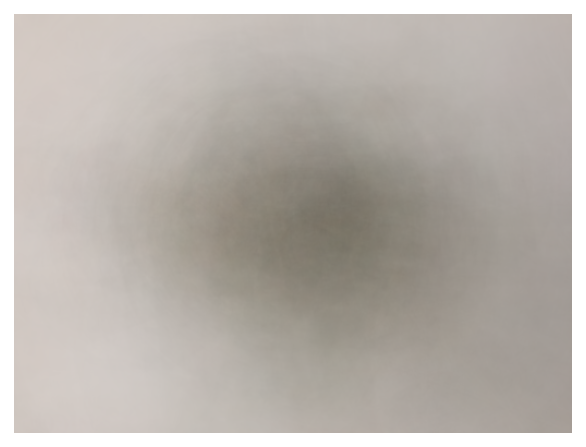

In [ ]:
glass_tensors = [tensor(Image.open(g_img)) for g_img in glass_imgs]
print(len(glass_tensors))
plastic_imgs = (path/'train/plastic').ls()
plastic_tensors = [tensor(Image.open(g_img)) for g_img in plastic_imgs]
print(len(plastic_tensors))
metal_imgs = (path/'train/metal').ls()
metal_tensors = [tensor(Image.open(g_img)) for g_img in metal_imgs]
print(len(metal_tensors))

# stacking up all the images of glass, plastic and metal...
glass_stack = torch.stack(glass_tensors).float()/255
print(glass_stack.shape, glass_stack.ndim)

plastic_stack = torch.stack(plastic_tensors).float()/255
print(plastic_stack.shape, plastic_stack.ndim)

metal_stack = torch.stack(metal_tensors).float()/255
print(metal_stack.shape, metal_stack.ndim)

mean_glass_tensor = glass_stack.mean(0)
print("mean shape of glass tensor ==>", mean_glass_tensor.shape)

mean_metal_tensor = metal_stack.mean(0)
show_image(mean_metal_tensor)

show_image(mean_glass_tensor)

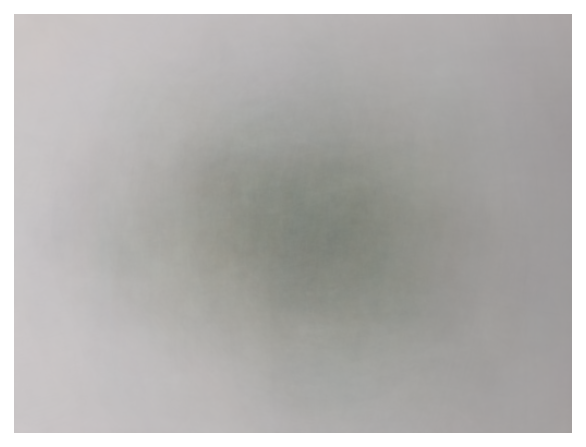

In [ ]:
mean_plastic_tensor = plastic_stack.mean(0)
show_image(mean_plastic_tensor)

In [ ]:
# Example 1: To check which is the closest to mean pizels of glass image....

diff1 = (glass_stack[1] - mean_glass_tensor).abs().mean()
print(diff1)


diff2 = (glass_stack[1] - mean_plastic_tensor).abs().mean()
print(diff2)


diff3 = (glass_stack[1] - mean_metal_tensor).abs().mean()
print(diff3)

# Clearly the lowest distance can be found for the glass tensors, then plastic and metal follow along in ranking..
# Hence this ia a baseline model to classify this as a glass tensor

tensor(0.0943)
tensor(0.0994)
tensor(0.1026)


In [ ]:
# takes the mean across x and y axis
def glass_distance(a,b): return (a-b).abs().mean((-1, -2))
def is_glass(x): return glass_distance(x,mean_glass_tensor[:, :, 0]) < glass_distance(x,mean_plastic_tensor[:, :, 0])


In [ ]:
is_glass(plastic_stack[-1][:, :, 0]), is_glass(plastic_stack[-1][:, :, 0]).float()

(tensor(False), tensor(0.))

In [ ]:
valid_path = (path/'valid/glass').ls()
print(len(valid_path))
valid_path = (path/'valid/plastic').ls()
print(len(valid_path))

valid_path = (path/'train/glass').ls()
print(len(valid_path))
valid_path = (path/'train/plastic').ls()
print(len(valid_path))

#######

valid_path = (path/'valid/plastic').ls()
plastic_imgs = [Image.open(img) for img in valid_path]
plastic_valid_tens = torch.stack([tensor(Image.open(img)) for img in valid_path])
plastic_valid_tens = plastic_valid_tens.float()/255
valid_plastic_tens = plastic_valid_tens[:, :, :, 0]

trues  = [i for i in is_glass(valid_plastic_tens) if i == True]
false = [i for i in is_glass(valid_plastic_tens) if i == False]
total = trues + false
all = len(total)
print(len(trues), len(false))


124
120
242
241
68 52


Accuracy of our initial base line model constructed on the fact of comparing average image pixels with new glass or metal image.

In [ ]:
valid_path = (path/'valid/glass').ls()
glass_imgs = [Image.open(img) for img in valid_path]
#print(valid_path)
glass_valid_tens = torch.stack([tensor(Image.open(img)) for img in valid_path])
glass_valid_tensors = glass_valid_tens.float()/255

valid_glass_tens = glass_valid_tensors[:, :, :, 0]
accuracy_glass =      is_glass(valid_glass_tens).float() .mean()
accuracy_plastic = (1 - is_glass(valid_plastic_tens).float()).mean()

# simple accuracy formula to compute...
print(accuracy_glass,accuracy_plastic,(accuracy_plastic+accuracy_glass)/2)

A simplistic implementation of creating a base line model to see why model can get confuse between metal, glass images because the distances of these tensors are very close to each other. In simpler terms these are most correlated ones..

Let's try to put our model into implementation by first apply augmented transforms to it and then putting these details into our model. Here are some details about the function

In [ ]:
doc(aug_transforms)

Next Important class is ImageDataLoaders.

ImageDataLoaders - Wrapper around the DataLoaders with factory methods for computer visions.

In simpler terms and ImageDataLoaders have several helper functions which can easily load the data as a DataLoader object. 

**According to the docs of fast.ai** [ImageDataLoader Doc](https://docs.fast.ai/vision.data#ImageDataLoaders)

This class should not be used directly, one of the factory methods should be preferred instead. All those factory methods accept as arguments:

1. item_tfms: one or several transforms applied to the items before batching them
2. batch_tfms: one or several transforms applied to the batches once they are formed
3. bs: the batch size
4. val_bs: the batch size for the validation DataLoader (defaults to bs)
5. shuffle_train: if we shuffle the training DataLoader or not
device: the PyTorch device to use (defaults to default_device())





In [ ]:
doc(ImageDataLoaders)

In [ ]:
tfms = aug_transforms(do_flip=True,flip_vert=True)
data= ImageDataLoaders.from_folder(path, train = "train", valid = "valid", 
                                    batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],bs = 16)

**Important Note from Transformations perspective**

1. Normalize.from_stats(*imagenet_state): Here we are saying that normalize each image with respect to imagenet_stats (imagenets dimension across 3 channels), basically this gives us the mean and standard deviation tensors of 3 dimensions.

Idea is to bring each pixel value close to the center, so that data dimensions are of approximately the same scale. We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier).

For example in case of RGB channels, we will do this process for each of the channel by simple formula. Here is a demonstration of how to perform normalization with python using numpy library.

X /= np.std(X, axis = 0)


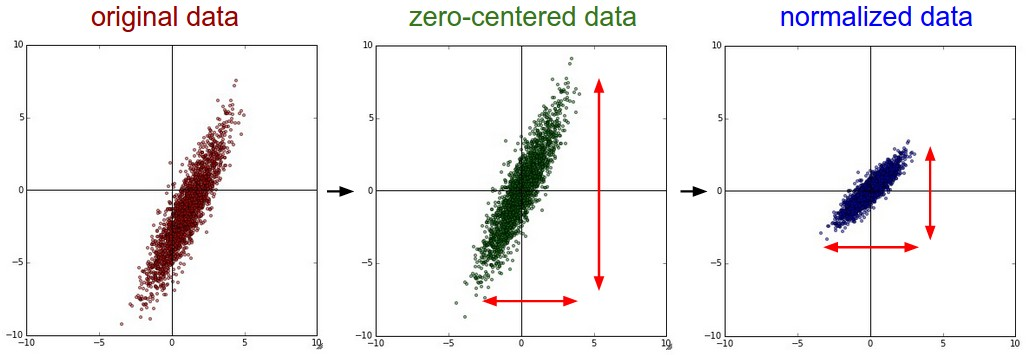

image source - https://cs231n.github.io/neural-networks-2/





The batch size bs is how many images you'll train at a time. Similarly, we can specify the valid batch size, which defaults to bs we have provided. Smaller bs will work for computers with less memory.

You can use aug_transforms() function to augment your data. I'll compare the results from flipping images horizontally and vertically.

In [ ]:
print(data.vocab)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


**show_batch function fast.ai**

A sample image can be seen from data.show_batch method

Takes into argument figure size tuple

This function display the batches of images to quickly glance at the data we are playing around with.

Some most common used arguments

1. rows: To specify number of rows we want to display in our batches of images

In [ ]:
type(data)

fastai.data.core.DataLoaders

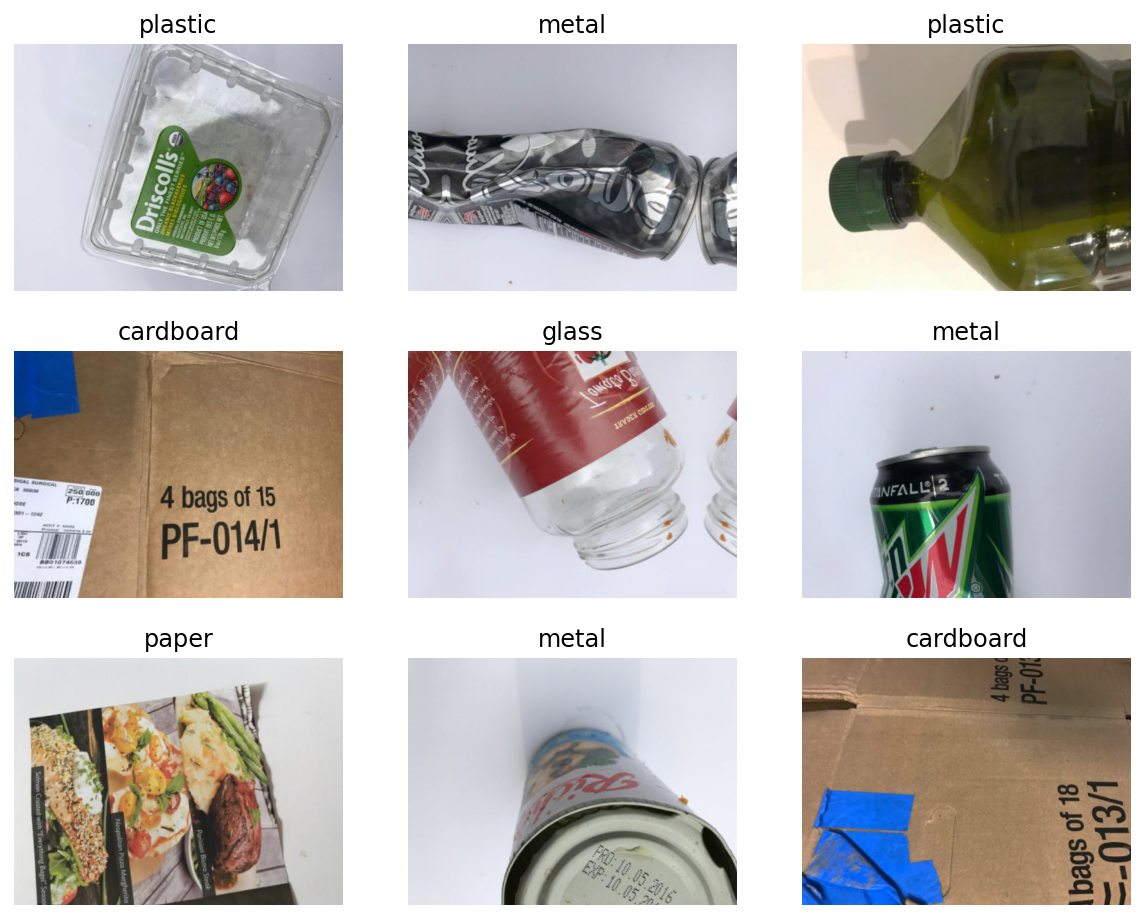

In [ ]:
# Applying show_batch function to our data loader object 'data' and visualize some of the images
data.show_batch(figsize=(10,8))

### **Building our Waste Classifier Model**

If you run the program with CUDA_LAUNCH_BLOCKING=1, this will help get a more exact stack trace

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# just one line to create our state of the art transfer learning model
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Cite - [Notebook link ](https://github.com/collindching/waste-sorter/blob/master/Waste%20sorter.ipynb)

### What is resnet34?

A residual neural network is a [convolutional neural network (CNN)](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca) with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

Since they're capable of describing more complexity, deep neural networks should theoretically perform better than shallow networks on training data. In reality, though, deep neural networks tend to perform empirically worse than shallow ones. 

Resnets were created to circumvent this glitch using a hack called shortcut connections. If some nodes in a layer have suboptimal values, you can adjust weights and bias; if a node is optimal (its residual is 0), why not leave it alone? Adjustments are only made to nodes on an as-needed basis (when there's non-zero residuals). 

When adjustments are needed, shortcut connections apply the identity function to pass information to subsequent layers. This shortens the neural network when possible and allows resnets to have deep architectures and behave more like shallow neural networks. The 34 in resnet34 just refers to the number of layers.

Here is an interesting links for RESNET architecture

https://blog.roboflow.com/custom-resnet34-classification-model/

In [ ]:
doc(learn.model)

### Viewing Transformations in action for one image

In [ ]:
# taking one image sample
tr_glass_imgs = os.listdir(str(path)+'/train/glass')[0]
ig=PILImage(PILImage.create(str(path)+'/train/glass/'+tr_glass_imgs).resize((600,400)))

In [ ]:
type(array(ig))

numpy.ndarray

In [ ]:
# Small example - Consider a tensor 
sample_tensor = torch.randn(5,4)
# next step is to use permute method
after_permute_operation = sample_tensor.permute(1, 0) 
# permute(1, 0) -> this is essentially swapping up the two axis
print(after_permute_operation.shape)
assert after_permute_operation.shape[0] == 4

torch.Size([4, 5])


In [ ]:
array(ig).shape

(400, 600, 3)

In [ ]:
# Using TensorImage class to convert the numpy.ndarray to tensors
# permute method - Used to reorder or reorganize the dimensions of an image
timg = TensorImage(array(ig)).permute(2,0,1).float()/255.
# Below function expands the dimension to the new batch size to an existing image shape.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

In [ ]:
# A simple and a short glance into fastai classes and functions related to transformations..
tfms = aug_transforms(do_flip=True)
for i in tfms:
  # Tfms which is a transform object takes into account two class when we pass an argument, do_flip=True
  print("Class ===>>>>", i, i.__getattribute__)
  # We can now create an object of all the transformations class and then pass our tensor form of images, shown in below code...

Class ===>>>> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes:  <method-wrapper '__getattribute__' of Flip object at 0x7ff627724d10>
Class ===>>>> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes:  <method-wrapper '__getattribute__' of Brightness object at 0x7ff627724850>


In [ ]:
# Performing image transformations through function..
y = _batch_ex(2) 
for t in tfms: 
  # split_idx = 0 refers to we are passing train image.. split_idx = 1, refers to validation in fastai
  y = t(y, split_idx=0)
  
_,axs = plt.subplots(1,2, figsize=(10,8))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

### Choosing a Learning Rate

Fast Ai uses **one cycle policy** which simply means, that learning rate will first start with low value, bouncing back to the large values and then being stable with value lower than the initial LR value, this has shown impressive results as it means we are not ending with either a slow or a very high LR.

To choose the best LR, one must look at the point where loss curve is the steepest. Please note that steepest point doesn't mean the point of minimum loss. It means point where loss is dropping faster..

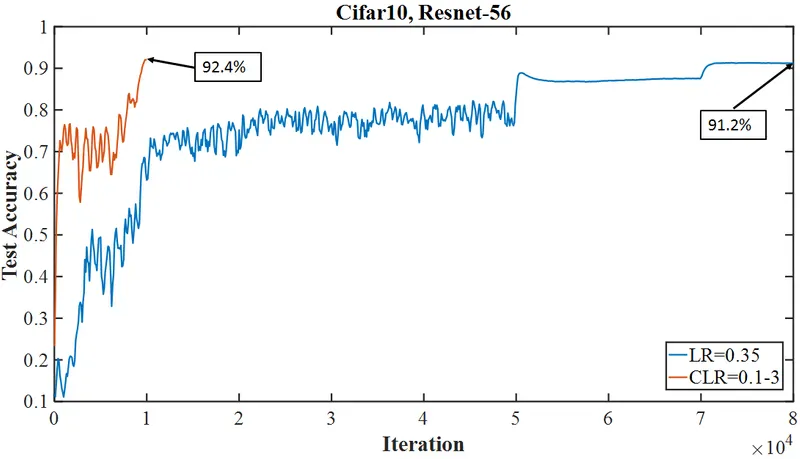

image source - https://iconof.com/1cycle-learning-rate-policy/

In [ ]:
# start_lr = starting learning rate
# end_lr = maximum learning rate at which we want the model to stop finding LR.
learn.lr_find(start_lr=1e-6,end_lr=1e1)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


SuggestedLRs(valley=0.0012022644514217973)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


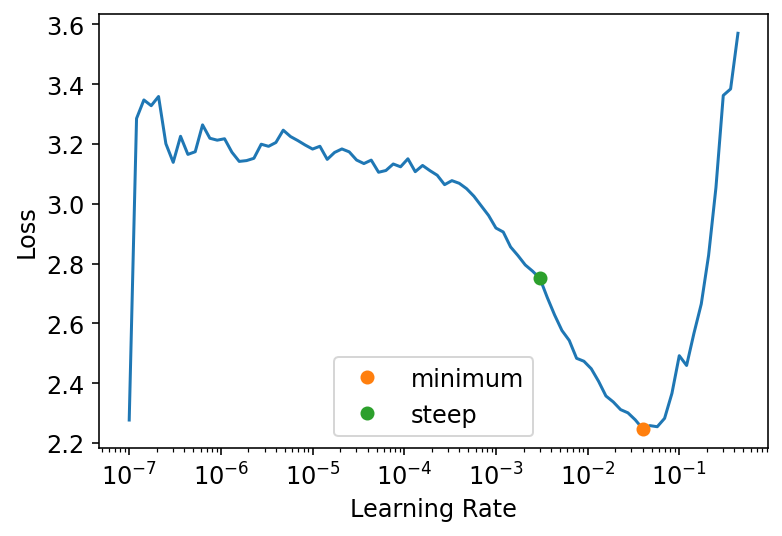

In [ ]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
# here is a simple way to find some random number between two numbers in an interval, which can help in guessing what might be the optimal LR
import numpy as np
np.random.uniform(1e-4, 1e-3)

0.0007015538560113359

In [ ]:
# fit_one_cycle - method to run the model to some certain epochs, lower epochs 
# One epoch - complete cycle of forward propagation/back propagation
learn.fit_one_cycle(20, lr_max=5e-03)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


The model ran for 20 epochs giving us the minimum loss of 0.066 which is better than the previous model, which was around 0.08. Hence, we are able to reduce the loss and increase the accuracy which will see later.

### VIsualizing most incorrect images

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
plt.figure(figsize=(10, 8))
interp.plot_top_losses(4, nrows=2)
plt.show()

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


<Figure size 720x576 with 0 Axes>

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


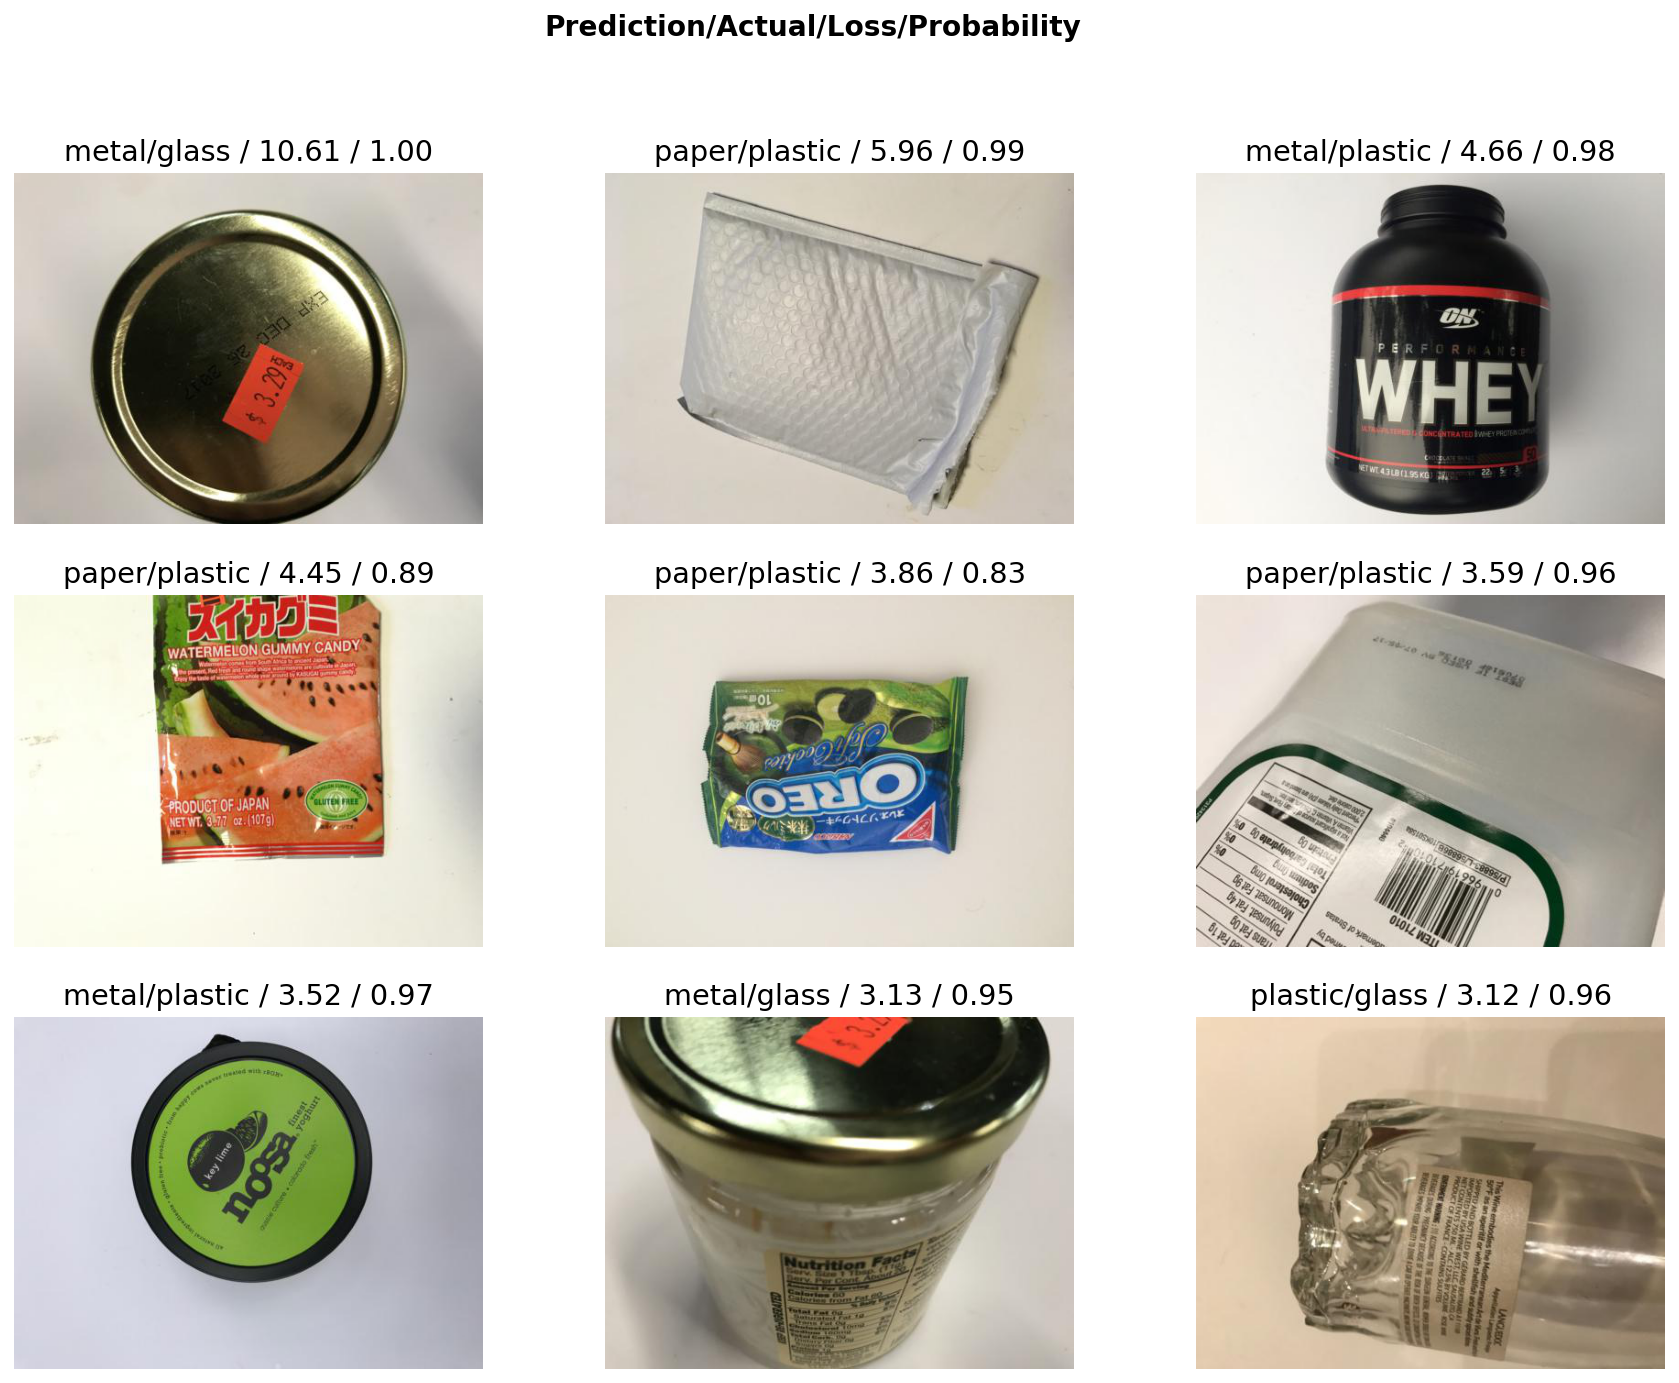

In [ ]:
interp.plot_top_losses(10, figsize=(15,11))

The images here are the ones after the removal of some over exposure of light in images, which was not the case with previous notebook of collindching. This has created an impact as now our model is less confused and hence the loss decreased.

In [ ]:
# Here's a documentation of plot_top_losses  function would look like...
doc(interp.plot_top_losses)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In the previous version of this notebook by collindching, The model often confused plastic for glass and confused metal for glass. The list of most confused images is below. Let's see are we able to reduce the overall misclassification error for the categories or not later.

In [ ]:
# checking where our model got most confused in classifying...
interp.most_confused(min_val=2)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


[('glass', 'metal', 7),
 ('cardboard', 'paper', 5),
 ('glass', 'plastic', 5),
 ('plastic', 'metal', 4),
 ('plastic', 'paper', 4),
 ('trash', 'paper', 4),
 ('metal', 'paper', 2),
 ('metal', 'plastic', 2),
 ('plastic', 'trash', 2)]

### 4. Predicting the test data

To see how this mode really performs, we need to make predictions on test data. First, I'll make predictions on the test data using the learner.get_preds() method. 

**Note:** learner.predict() only predicts on a single image, while learner.get_preds() predicts on a set of images. I highly recommend reading the [documentation](https://docs.fast.ai/basic_train.html#Learner.get_preds) to learn more about predict() and get_preds().

In [ ]:
doc(learn.predict)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


### Loading Test DataLoader for Prediction

In the above cells, we have defined data loader for our train and validation set..

However, for our model to predict on the new image data, we will have load into a dataloader object.

We can simply pass the images of test folder into get_image_files function, which will traverse the test folder and get us all the images in test folder.

get_preds is the function which gives us the probabilities of our image being of each class


In [ ]:
#get predictions..
test_dl = data.test_dl(get_image_files(os.path.join(path, 'test')))
preds = learn.get_preds(dl=test_dl)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
print(preds[0].shape)
preds[0]

torch.Size([631, 6])


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


TensorBase([[1.7182e-04, 7.1475e-05, 1.5689e-03, 2.3538e-05, 9.9789e-01, 2.7502e-04],
        [8.1237e-08, 5.9949e-08, 1.6182e-08, 9.9999e-01, 1.9660e-07, 1.1921e-05],
        [1.3310e-06, 6.2397e-03, 9.9346e-01, 4.1719e-07, 2.6252e-04, 3.6827e-05],
        ...,
        [5.1307e-06, 5.3394e-05, 9.9495e-01, 1.8174e-04, 9.8943e-05, 4.7127e-03],
        [1.7216e-07, 1.0502e-05, 7.9543e-04, 7.6339e-06, 9.9208e-05, 9.9909e-01],
        [8.3721e-06, 5.6436e-08, 6.0167e-08, 9.9991e-01, 1.5351e-05, 6.4679e-05]])

### Converting probabilities to a class names

Simple approach - For one set of image, get the maximum probability value among 6 classes.

Choose the one with maximum value along the 1 axis i.e columns

Rows - Probabilities for other sample of images

In [ ]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
# Append the class labels with index found from maximum probability class..
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
classes = data.vocab
print(classes)
yhat = []
for max_idx in max_idxs:
    yhat.append(classes[max_idx])

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
# yhat => predicted class
yhat

['plastic',
 'paper',
 'metal',
 'paper',
 'cardboard',
 'cardboard',
 'paper',
 'trash',
 'cardboard',
 'glass',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'glass',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'glass',
 'paper',
 'glass',
 'paper',
 'trash',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'paper',
 'paper',
 'paper',
 'plastic',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'trash',
 'metal',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'glass',
 'paper',
 'cardboard',
 'glass',
 'plastic',
 'glass',
 'paper',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'cardboard',
 'plastic',
 'glass',
 'paper',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'metal',
 'paper',
 'plastic',
 'trash',
 'metal',
 'plastic',
 'cardboard',
 'metal',
 'metal',
 'glass',
 'glass',
 'plastic',
 'glass',
 'glass',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'paper',
 'metal',
 'paper',
 'metal',
 'metal',
 'card

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
# A quick check on what get_image_files does...
l = get_image_files(os.path.join(path, 'test'))

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
from PIL import Image

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


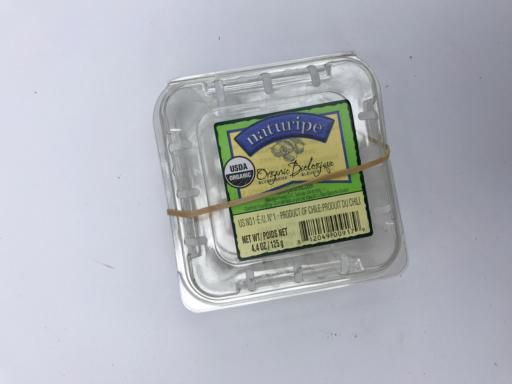

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
Image.open(l[0])

In [ ]:
# Validate against the test set...
learn.validate(dl=test_dl)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


(#2) [None,None]

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in test_dl.items:
    y.append(str(label_path))
    
# then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
y

['plastic',
 'paper',
 'metal',
 'paper',
 'cardboard',
 'cardboard',
 'paper',
 'trash',
 'cardboard',
 'glass',
 'plastic',
 'plastic',
 'paper',
 'cardboard',
 'glass',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'glass',
 'paper',
 'glass',
 'paper',
 'trash',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'paper',
 'paper',
 'paper',
 'plastic',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'trash',
 'metal',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'glass',
 'paper',
 'cardboard',
 'glass',
 'plastic',
 'glass',
 'paper',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'cardboard',
 'plastic',
 'glass',
 'paper',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'metal',
 'paper',
 'plastic',
 'trash',
 'metal',
 'plastic',
 'cardboard',
 'metal',
 'metal',
 'glass',
 'glass',
 'plastic',
 'metal',
 'glass',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'paper',
 'metal',
 'paper',
 'metal',
 'metal',
 'ca

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


### Creating a Dataframe of the results observed

In [ ]:
## predicted values
print(yhat[0:30])
## actual values
print(y[0:30])
df_dict = {'actual': y, 'predicted': yhat}
pd.DataFrame(df_dict)


['plastic', 'paper', 'metal', 'paper', 'cardboard', 'cardboard', 'paper', 'trash', 'cardboard', 'glass', 'plastic', 'paper', 'paper', 'cardboard', 'glass', 'plastic', 'glass', 'plastic', 'plastic', 'glass', 'paper', 'glass', 'paper', 'trash', 'cardboard', 'paper', 'plastic', 'metal', 'paper', 'paper']
['plastic', 'paper', 'metal', 'paper', 'cardboard', 'cardboard', 'paper', 'trash', 'cardboard', 'glass', 'plastic', 'plastic', 'paper', 'cardboard', 'glass', 'plastic', 'glass', 'plastic', 'plastic', 'glass', 'paper', 'glass', 'paper', 'trash', 'cardboard', 'paper', 'plastic', 'metal', 'paper', 'paper']


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


actual  predicted
0      plastic    plastic
1        paper      paper
2        metal      metal
3        paper      paper
4    cardboard  cardboard
..         ...        ...
626    plastic    plastic
627      glass      glass
628      metal      metal
629      trash      trash
630      paper      paper

[631 rows x 2 columns]

It looks the first five predictions match up! (check)

How did we end up doing? Again we can use a confusion matrix to find out.

### Test confusion matrix

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 96   0   2   2   1   0]
 [  0 111   5   0   6   0]
 [  0   5  98   0   0   0]
 [  1   0   0 145   1   2]
 [  0   2   0   1 117   1]
 [  0   0   0   5   3  27]]


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


### Visualising Confusion Matrix of Test Set

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


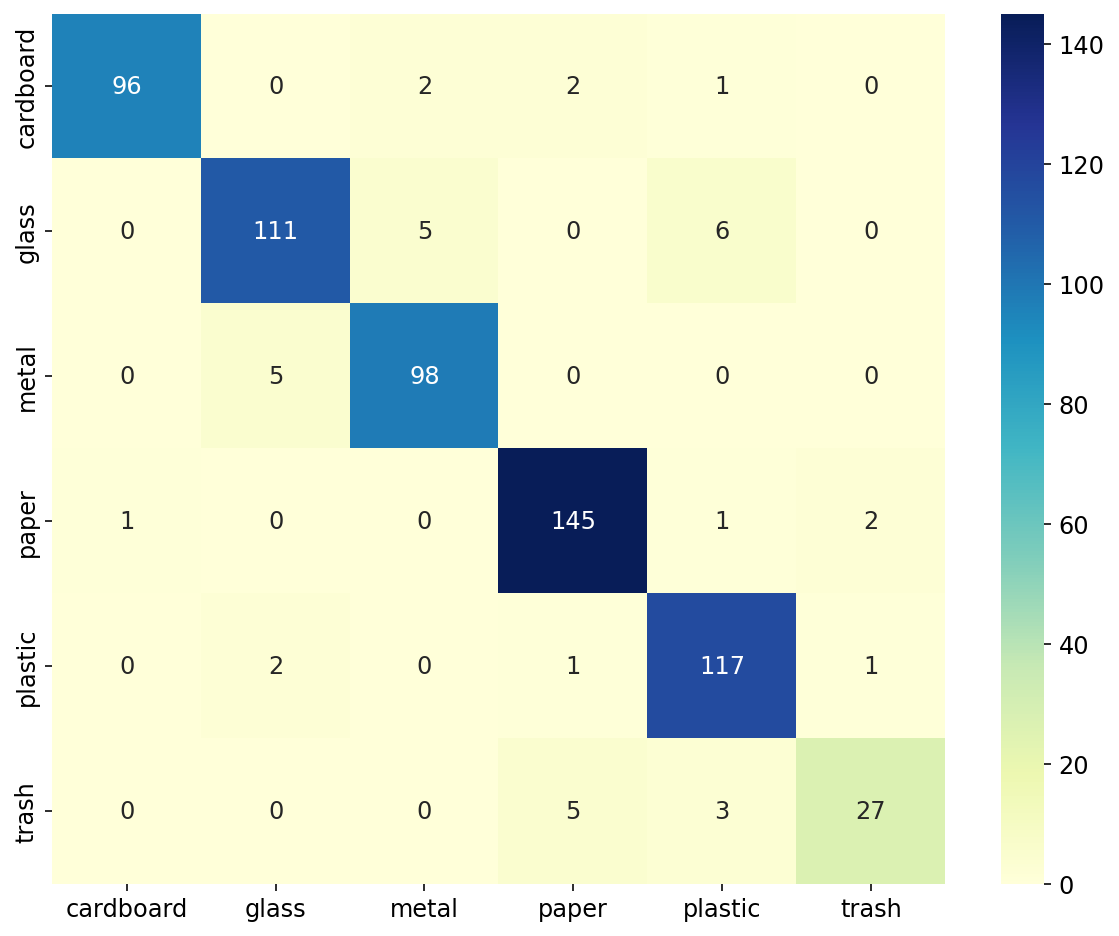

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [ ]:
correct = 0
for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

0.9413629160063391

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


We ended up achieving 94.1% accuracy which is slightly better than previous notebook. Also, we were able to work on the next steps mentioned by collindching's notebook and reduce misclassification error as well.

### Comparing our confusion matrix with previous confusion matrix

Collindching's version of CM Vs My version

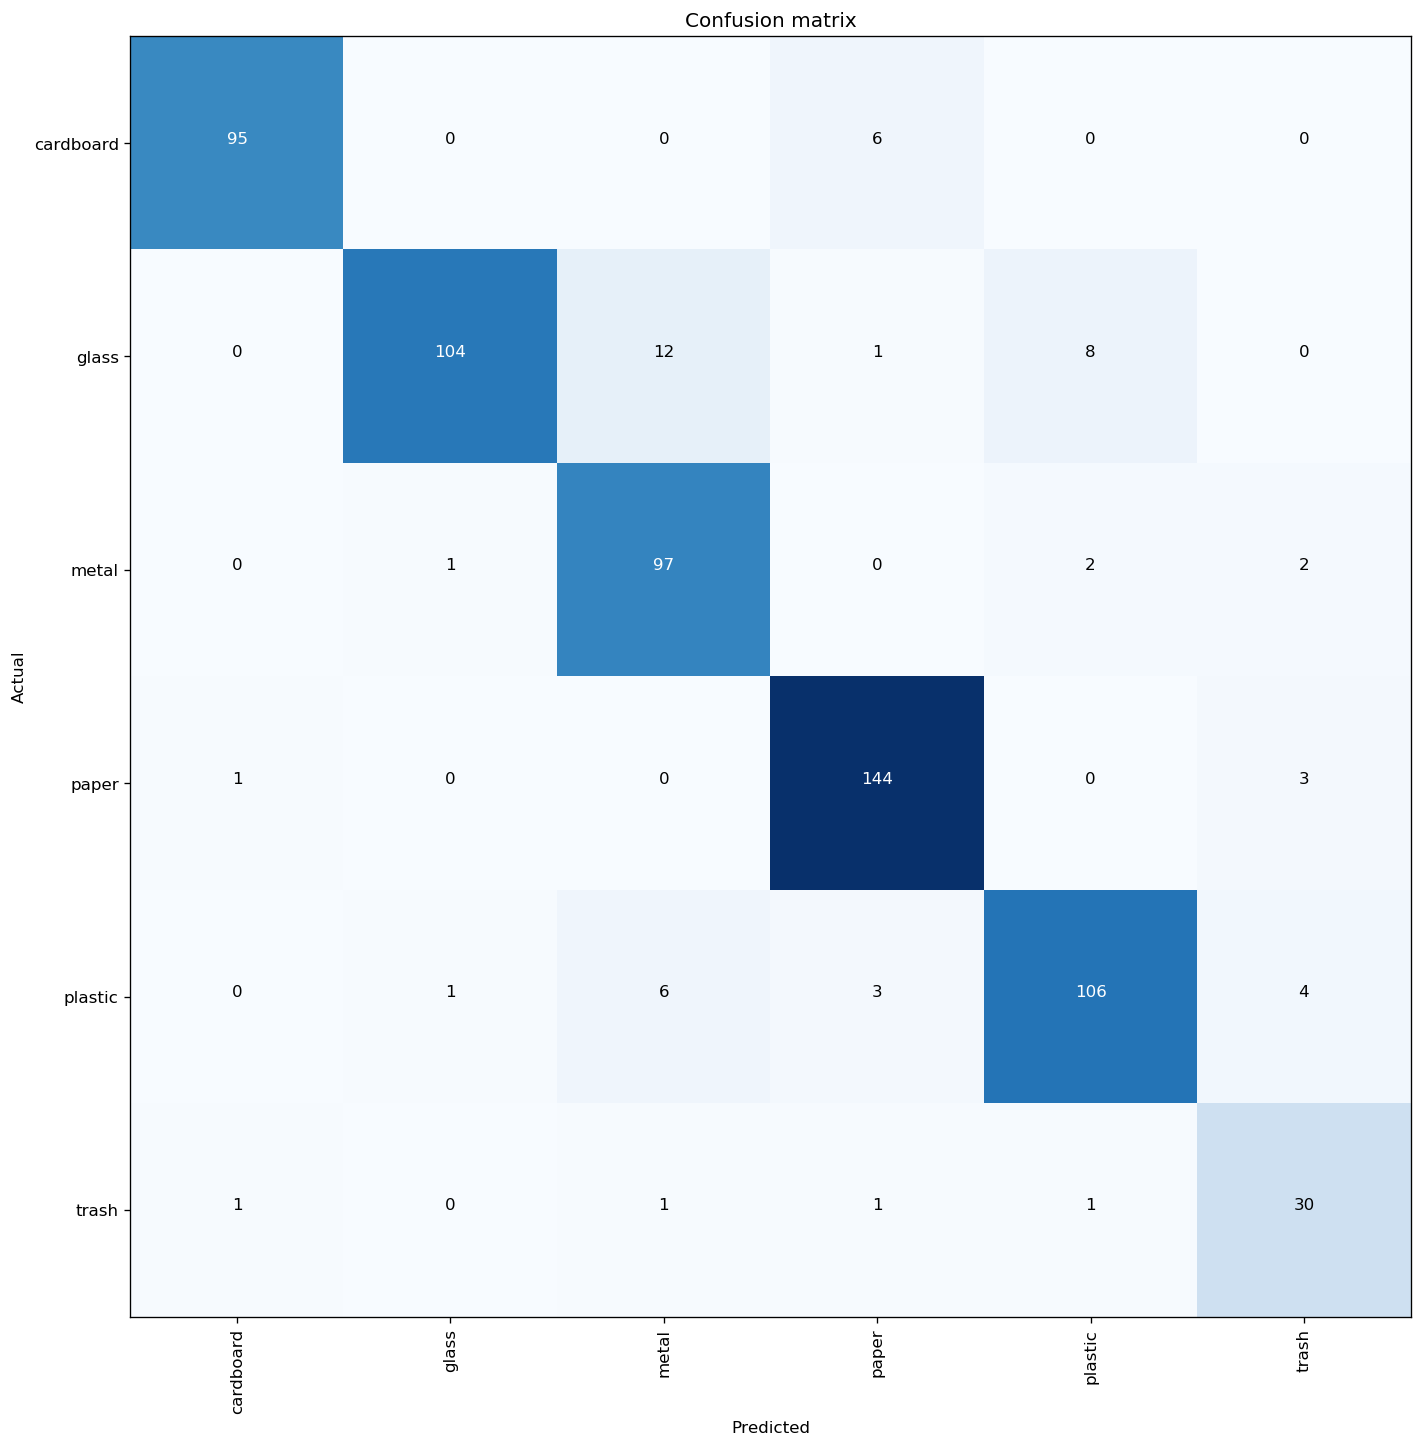




My Version 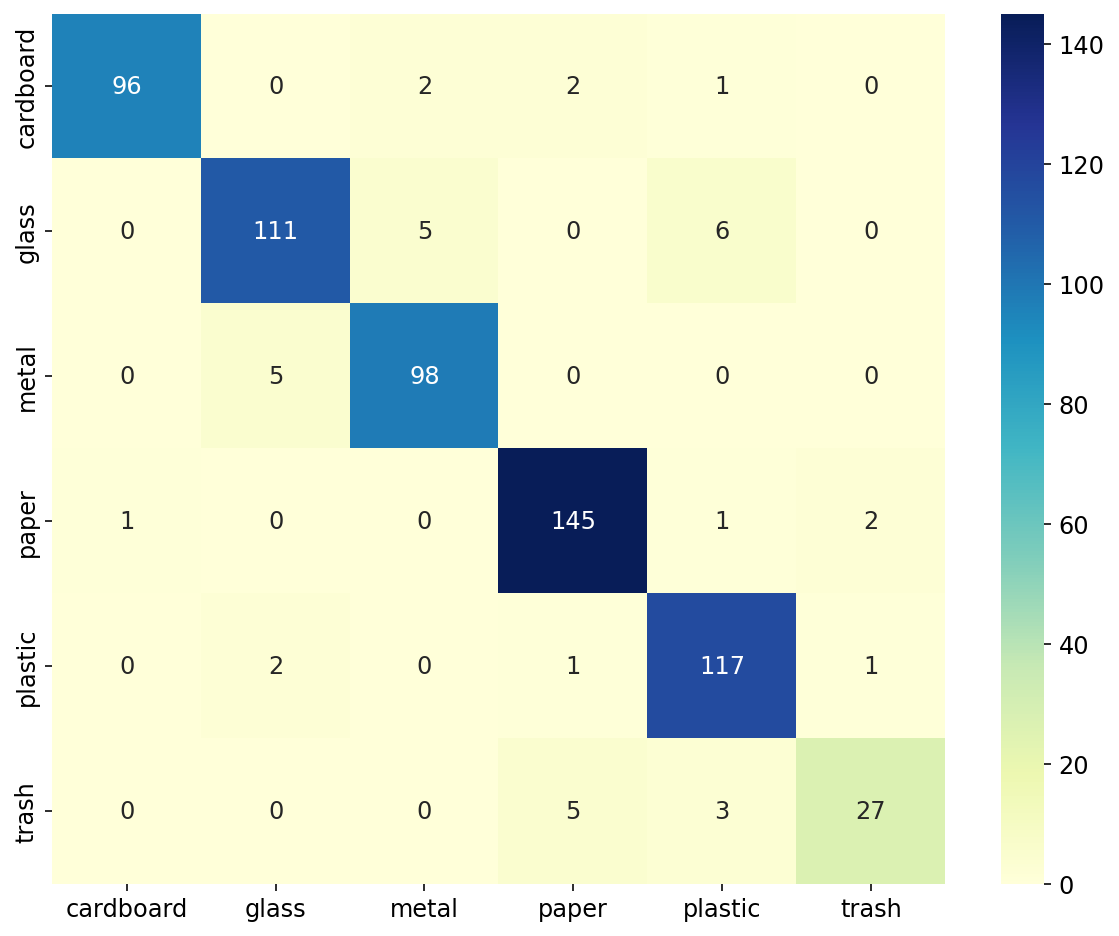

Google Collaboratory Link for the code and experiments

https://github.com/amay1212/Waste-Sorting/blob/master/Waste_Sorter%20Extended.ipynb

In [ ]:
# hide
## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')

### Further enhancements and Research area

1. To improve accuracy even further for the misclassified results.

2. To try and test this model with back rep using the below 

  https://www.mdpi.com/2313-433X/7/8/144/pdf#:~:text=BackRep%20consists%20of%20a%20data,solid%20waste%20is%20usually%20littered.

3. To see if we can distinguish more clearly between dry and wet waste in particular.